<a href="https://colab.research.google.com/github/Jaronex/metropolis-hastings-projects/blob/main/metropolis_hastings_widget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is a code-along to *The Metropolis-Hastings Algorithm* by Dirty Quant. The original notebook can be found [here](https://github.com/tinoproductions/DirtyQuant/blob/master/The%20Metropolis-Hastings%20Algorithm.ipynb). My goal is to understand the underlying mechanisms behind Metropolis-Hastings sampling and eventually integrate it into more sophisticated models e.g. [MHGAN](https://arxiv.org/pdf/1811.11357.pdf), [PMH](https://arxiv.org/pdf/1511.01707.pdf) etc. 

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, Output, Button, IntText, Label, FloatText

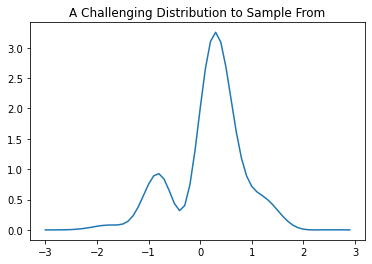

In [ ]:
# ignoring intractable normalising constants/integral in denominator
def targetdist(x):
  probX = np.exp(-x**2) * (2 + np.sin(x*5) + np.sin(x*2))
  return probX
x = np.arange(-3, 3, 0.1)
y = targetdist(x)
plt.title('A Challenging Distribution to Sample From')
plt.plot(x, y);

## Generating Samples 

We want to define a Markov chain over $x_k \forall \; k = {1, 2...,n}$ so that as $n \rightarrow ∞$, $x_n \sim P(x)$.

With knowledge of current state $x_n$ and next state $x_{n+1}$, we proceed with:

1.   Generating candidate $x_*$ from proposal distribution $Q(X_*|x_n)$, which must be dependent on current state $x_n$ e.g. $x_*|x_n \sim N(x_n, \sigma^2)$, where we punch in our own value of $\sigma$. This is the Gaussian proposal as coded in [Justin Ellis' notebook](https://github.com/jellis18/practical_mcmc/blob/master/nbs/part1.ipynb).
2.   Calculating acceptance probability $A(x_n → x_*) = min(1, \frac{P(x_*)}{P(x_n)} \frac{Q(x_n|x_*)}{Q(x_*|x_n)} )$ to determine acceptance-rejection. $\frac{P(x_*)}{P(x_n)}$ is computed by substituting in the values of $x_*$ 
and $x_n$. $\frac{Q(x_n|x_*)}{Q(x_*|x_n)}$ is the ratio of the probability of transitioning to current state $x_n$ given future state $x_*$ over the probability of transitioning to future state $x_*$ given future state $x_n$.
3.   Draw from $u \sim U(0,1)$. 
\begin{equation}
x_{n+1} = \Bigg\{
    \begin{array}{lr}
        x_* \text{if } u \leq A(x_n → x_*)\\
        x_n \text{if } u > A(x_n → x_*)\\
    \end{array}
\end{equation}


In [ ]:
### parameters ###
burnin = 10  # number of burn-in iterations
lag = 1  # iterations between successive samples
nsamp = 1000 # number of samples to draw
sig = 1 # standard deviation of Gaussian proposal
x = -1 # start point
### storage ###
X = np.zeros((nsamp,1)) # samples drawn from the Markov chain
acc = np.array((0, 0))  # vector to track the acceptance rate

def run_mcmc(caller):
  out.clear_output() # clear output of cell
  display_label.value = 'Running MCMC'
  ### params
  burnin = burnin_input.value # no. of burn-in/throwaway iterations
  lag = lag_input.value # iterations between successive samples
  nsamp = nsamp_input.value # no. of samples to draw
  sig = sig_input.value # s.d. of Gaussian proposal
  x = start_point_input.value # start point
  ### storage
  X = np.zeros((nsamp, 1)) # samples drawn from Markov chain -> assume 1 dim (?)
  acc = np.array((0,0)) # vector to track acceptance rate

%matplotlib inline
run_button = Button(description = 'Run MCMC')
burnin_input = IntText(value=0, description = 'Burn-in')
lag_input = IntText(value=1, description ='Lag')
nsamp_input = IntText(value=1000, description ='Num Samples')
sig_input = FloatText(value=1.0, description ='Sigma')
start_point_input = FloatText(value='-1', description ='Start Value')
display_label  = Label(value = 'Ready to go!')
    
out = Output()

run_button.on_click(run_mcmc)

all_widgets = HBox([VBox([HBox([run_button, display_label]) ,
                    burnin_input,
                    lag_input,
                    nsamp_input,
                    sig_input,
                    start_point_input]),
                    out])

display(all_widgets)

In [ ]:
def MHstep(x0, sig):
  # generate candidate from Gaussian -> prop_fn
  xp = np.random.normal(loc=x0, scale=sig) # prop_fn_kwargs
  accprob = targetdist(xp) / targetdist(x0) # acceptance probability H
  u = np.random.rand() # draw random uniform no.
  if u <= accprob: # if accepted
    x1 = xp
    a = 1 # note acceptance
  else:
    x1 = x0
    a = 0
  return x1, a

# MH routine
for i in range(burnin):
  x, a = MHstep(x, sig); # iterate chain for 1 time-step
  acc = acc + np.array((a, 1)) # track accept-reject status

for i in range(nsamp):
  for j in range(lag):
    x, a = MHstep(x, sig) # iterate chain in 1 time-step
    acc = acc + np.array((a, 1)) # track accept-reject status
  X[i] = x # store the i-th sample

In [ ]:
df = pd.DataFrame(data=X, columns=['Trace'])
display_label.value = 'Average Acceptance:' + str(round(acc[0] / acc[1], 2))

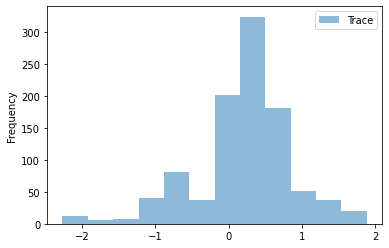

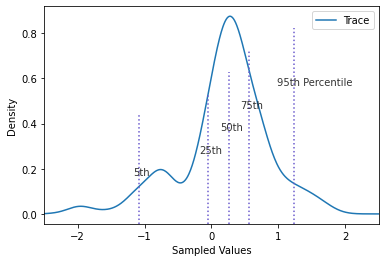

In [ ]:
# Plotting histogram and KDE
# plt.hist(X, bins=20, density=True, color='lightskyblue')
ax = df.plot.hist(bins=12, alpha=0.5)
ax = df.plot.kde(xlim=(-2.5,2.5))

# X
plt.xlabel("Sampled Values")
plt.ylabel("Density")

# Quantile lines
quant_5, quant_25, quant_50, quant_75, quant_95 = df.quantile(0.05), df.quantile(0.25), df.quantile(0.5), df.quantile(0.75), df.quantile(0.95)
quants = [[quant_5, 0, 0.5], [quant_25, 0, 0.6], [quant_50, 0, 0.7],  [quant_75, 0, 0.8], [quant_95, 0, 0.9]]
for i in quants:
  plt.axvline(i[0].item(), ymin = i[1], ymax = i[2], ls = ":", color='slateblue')

# Annotations
plt.text(quant_5-.1, 0.17, "5th", size = 10, alpha = 0.8)
plt.text(quant_25-.13, 0.27, "25th", size = 10, alpha = 0.8)
plt.text(quant_50-.13, 0.37, "50th", size = 10, alpha = 0.8)
plt.text(quant_75-.13, 0.47, "75th", size = 10, alpha = 0.8)
plt.text(quant_95-.25, 0.57, "95th Percentile", size = 10, alpha =.8)
    
plt.show()